In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as plt
import statsmodels.api as sm
import pandas as pd
import csv
import math
import plotly.graph_objects as go


from pandas import DataFrame, Series
from sklearn.preprocessing import MinMaxScaler
from  scipy.stats import norm
from scipy.signal import find_peaks

%matplotlib inline

from scipy.signal import savgol_filter

In [2]:
def normalization(columns): # -1~1사이의 값으로 정규화
    MinMax = (columns - columns.min(axis=0)) / (columns.max(axis=0) - columns.min(axis=0))
    MinMax = (MinMax * 2) 
    MinMax
    return MinMax

In [3]:
def SVM(x, y, z):
    svm = []
    for i in range(0, len(x)):
        svm.append(math.sqrt(x[i]*x[i]+y[i]*y[i]+z[i]*z[i]))
    return svm

In [4]:
def LPF(svm):
#     rawData['targetData'] = rawData['AccY']
    result = []
    ts = 0.01 # 100Hz
    tau = 0.1
#     print_graph(rawData['targetData'], 50)
#     print(rawData['targetData'])
#     tmpResult = Series(np.zeros(len(rawData.targetData)))
#     tmpResult[0] = rawData.targetData[0]
    tmpResult = Series(np.zeros(len(svm)))
    tmpResult[0] = svm[0]

    for i in np.arange(1, len(svm)):
        tmpResult[i] = (tau*tmpResult[i-1] + ts * svm[i]) / (ts + tau)

    result = tmpResult

#     plt.plot(rawData.SampleRate, rawData.targetData, '#afafaf',  rawData.SampleRate, rawData.LPF_X, 'b')
#     plt.grid(True)
#     plt.show()
#     print(rawData)
    return result

In [5]:
def print_graph(MinMax, num): # num is cut range
    length = len(MinMax)
    plt.figure(figsize=(20, 5)) # graph size
    plt.xticks(np.arange(0, length+1, num))
    plt.plot(MinMax)
    plt.show()

In [6]:
def cut_count(MinMax, cnt): # 왼발, 오른발의 데이터를 잘라서 구분 cnt = peak array
    step = []
#     print(MinMax)
    for i in range(1, len(cnt)):
        step.append(MinMax[cnt[i-1]:cnt[i]])
    return step

In [22]:
def ACF(step, cnt): #자기상관계수 구하는 함수, cnt = 한발에 들어가는 데이터의 수
    answer = 0
    acf = []
    num = 1
    for i in step:
        answer = 0
#         answer = np.linalg.norm(i)
        for j in i:
#             print(j)
            answer = answer + j*j
        answer = answer / cnt[num]
        num += 1
#         print(answer)
        acf.append(answer)
    return acf

In [21]:
def compare_acf(acf): # 자기상관계수 값을 구해줌
    num = len(acf) / 2
    left = []
    right = []
    result = []
#     print("acf_len : ", len(acf))
    if (len(acf) % 2 == 0) :
#         print("even")
        for i in range(1, len(acf), +2):
            left.append(acf[i])
            right.append(acf[i-1])
#         print(left, right)
        result = np.corrcoef(left, right)
        result = abs(result)
#         print("even", result)
    else :
#         print("odd")
        for i in range(1, len(acf)-1, +2):
            left.append(acf[i])
            right.append(acf[i-1])
#         print(left, right)
        result = np.corrcoef(left, right)
        result = abs(result)
#         print ("odd", result)
    return result

In [19]:
def main(rawData):
    x_data = rawData['AccX']
    y_data = rawData['AccY']
    z_data = rawData['AccZ']
    svm = SVM(x_data, y_data, z_data)
    lpf = LPF(svm)
    yhat = normalization(savgol_filter(lpf, 51, 3)) # window size 51, polynomial order 3
    # print_graph(yn, 50)
#     print_graph(yhat, 50)


    indices = find_peaks(yhat)[0]
    temp = []
    for i in indices :
        if (yhat[i] > 1.2):
            temp.append(i)
    peak = [temp[0]]
    for i in range(1, len(temp)):
        if (temp[i]-temp[i-1] > 30):
            peak.append(temp[i])
#     print("peak : ", peak)

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        y=yhat,
        mode='lines+markers',
        name='Original Plot'
    ))

    fig.add_trace(go.Scatter(
        x=peak,
        y=[yhat[j] for j in peak],
        mode='markers',
        marker=dict(
            size=8,
            color='red',
            symbol='cross'
        ),
        name='Detected Peaks'
    ))

#     fig.show()
    distance = []
    value = 0
    for i in range(1, len(peak)):
        if (peak[i]-peak[i-1] > 30):
            distance.append(peak[i]-peak[i-1])
#     print("distance : ", distance)

    step = cut_count(yhat, peak)
#     print("step_len : ", len(step))
    acf = ACF(step, peak)
#     print(acf)
    compare = compare_acf(acf)
#     print(compare)

    result = True
    if (compare[0][1] > 0.6):
        result=  True
    else : result = False
    if (result == True):
        print('\033[34m', result, '\033[0m', compare[0][1])
    else : print('\033[31m', result, '\033[0m', compare[0][1])

In [25]:
for i in range(0, 5):
    rawData = pd.read_csv(f'abnormal/abnormalWalk{i}.csv')
    main(rawData)

 True  1.0
 True  1.0
 True  1.0
 True  0.8396863519190217
 True  0.9957386549756645


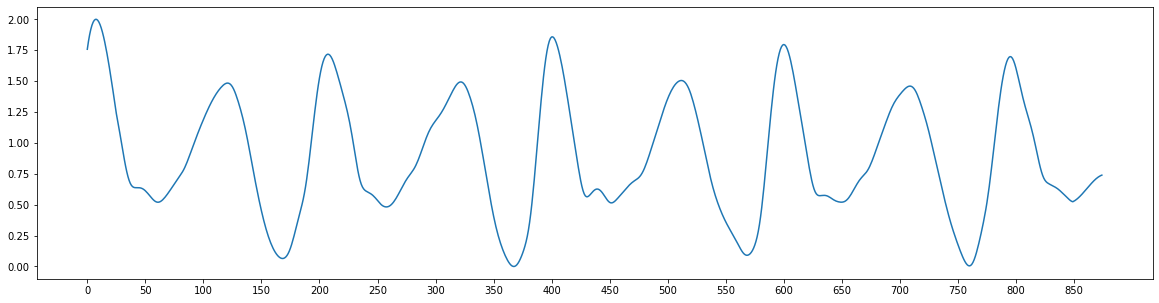

NameError: name 'go' is not defined

In [11]:
rawData = pd.read_csv('normal/normalWalk2.csv')
lpf = LPF(rawData)
yhat = normalization(savgol_filter(lpf.LPF, 51, 3)) # window size 51, polynomial order 3
# print_graph(yn, 50)
print_graph(yhat, 50)


indices = find_peaks(yhat)[0]
peak = []
for i in indices :
    if (yhat[i] > 1.5):
        peak.append(i)

fig = go.Figure()
fig.add_trace(go.Scatter(
    y=yhat,
    mode='lines+markers',
    name='Original Plot'
))

fig.add_trace(go.Scatter(
    x=peak,
    y=[yhat[j] for j in peak],
    mode='markers',
    marker=dict(
        size=8,
        color='red',
        symbol='cross'
    ),
    name='Detected Peaks'
))

fig.show()